In [4]:
!pip install ollama
!pip install langchain
!pip install llama-cpp-python

First serve the model:

```
ollama pull llama2

ollama run ollama2
```


In [2]:
from langchain_community.llms import Ollama
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

class WrappingStreamingStdOutCallbackHandler(StreamingStdOutCallbackHandler):
    def on_llm_new_token(self, token: str, **kwargs) -> None:
        super().on_llm_new_token(token, **kwargs)
        # Implement wrapping logic
        max_width = 80  # Define your wrap width
        if len(token) > max_width:
            print(token[:max_width])
            print(token[max_width:])
        else:
            print(token, end='')

llm = Ollama(
    model="llama3", callback_manager=CallbackManager([StreamingStdOutCallbackHandler()])
)
response = llm.invoke("The first man on the moon was ...")


The first man to walk on the moon was Neil Armstrong, who stepped onto the lunar surface on July 20, 1969 as part of the Apollo 11 mission. Armstrong famously declared, "That's one small step for man, one giant leap for mankind," as he became the first person to walk on the moon.

In [3]:
from datasets import load_dataset

dataset = load_dataset("hellaswag")


/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/datasets/load.py:1486: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [4]:
dataset['train'][0]

{'ind': 4,
 'activity_label': 'Removing ice from car',
 'ctx_a': 'Then, the man writes over the snow covering the window of a car, and a woman wearing winter clothes smiles.',
 'ctx_b': 'then',
 'ctx': 'Then, the man writes over the snow covering the window of a car, and a woman wearing winter clothes smiles. then',
 'endings': [', the man adds wax to the windshield and cuts it.',
  ', a person board a ski lift, while two men supporting the head of the person wearing winter clothes snow as the we girls sled.',
  ', the man puts on a christmas coat, knitted with netting.',
  ', the man continues removing the snow on his car.'],
 'source_id': 'activitynet~v_-1IBHYS3L-Y',
 'split': 'train',
 'split_type': 'indomain',
 'label': '3'}

In [5]:
import pandas as pd 

# Convert to DataFrame for easier manipulation
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])
valid_df = pd.DataFrame(dataset['validation'])

In [17]:

# Summarize activity labels
train_summary = train_df['activity_label'].value_counts().reset_index()
train_summary.columns = ['Activity Label', 'Train Count']

test_summary = test_df['activity_label'].value_counts().reset_index()
test_summary.columns = ['Activity Label', 'Test Count']

# Merge the summaries for a complete view
summary_df = pd.merge(train_summary, test_summary, on='Activity Label', how='outer').fillna(0)
summary_df.sort_values(by='Train Count', ascending=False)
# Display the summary
# import ace_tools as tools; tools.display_dataframe_to_user(name="Activity Label Distribution Summary", dataframe=summary_df)

,Activity Label,Train Count,Test Count
60,Food and Entertaining,3962.0,518
35,Computers and Electronics,3715.0,408
72,Health,3415.0,438
76,Home and Garden,2813.0,353
57,Finance and Business,2046.0,265
...,...,...,...
68,Hammer throw,0.0,68
67,Grooming horse,0.0,60
184,Tug of war,0.0,72
51,Doing step aerobics,0.0,46


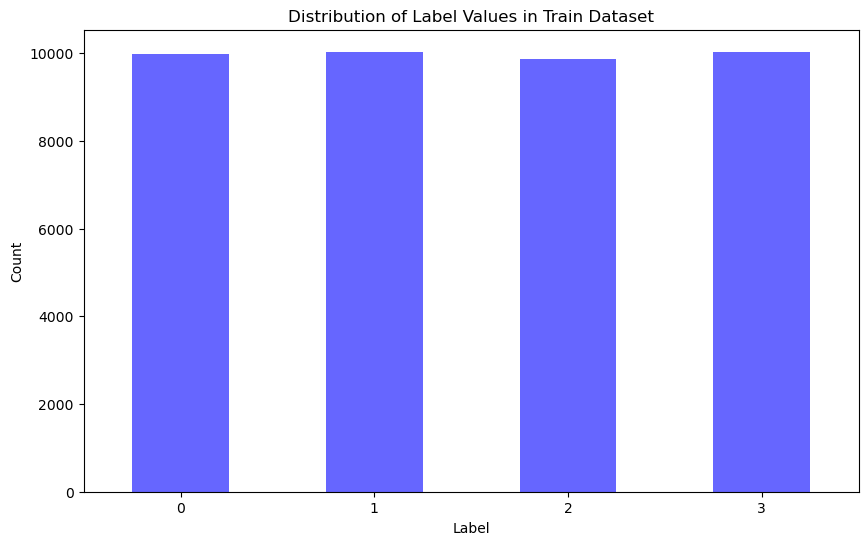

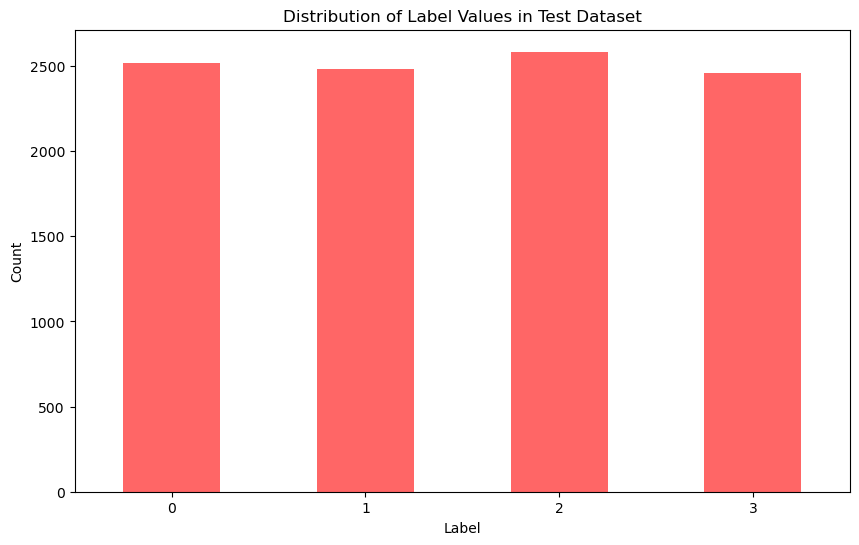

In [36]:
import matplotlib.pyplot as plt

# Plot the distribution of label values in the train dataset
plt.figure(figsize=(10, 6))
train_df['label'].value_counts().sort_index().plot(kind='bar', color='blue', alpha=0.6)
plt.title('Distribution of Label Values in Train Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Plot the distribution of label values in the test dataset
plt.figure(figsize=(10, 6))
valid_df['label'].value_counts().sort_index().plot(kind='bar', color='red', alpha=0.6)
plt.title('Distribution of Label Values in Test Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [1]:
import csv
import os
from langchain_community.llms import Ollama
from IPython.display import clear_output
from pprint import pprint

# Initialize the Llama 2 model using LangChain and Ollama
llm = Ollama(model="llama3")

# Function to format the HellaSwag example for multiple-choice
def format_example(example):
    question = example['ctx']
    choices = example['endings']
    return question, choices, int(example['label'])  # Ensure label is an integer

# Function to save predictions
def save_predictions(file_path, predictions):
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Index", "Predicted", "Correct", "Prompt", "Response"])
        writer.writerows(predictions)

# Function to load predictions
def load_predictions(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'r') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header
            return [(int(row[0]), int(row[1]), int(row[2])) for row in reader]
    return []

# Function to evaluate the model
def evaluate_model(dataset, file_path='train_predictions.csv'):
    # Load existing predictions if they exist
    predictions = load_predictions(file_path)
    completed_indices = {idx for idx, _, _ in predictions}
    correct = sum(1 for _, pred, label in predictions if pred == label)
    total = len(predictions)

    for idx, example in enumerate(dataset['train']):
        if idx in completed_indices:
            continue  # Skip already processed examples

        question, choices, label = format_example(example)
        clear_output(wait=True)
        prompt = "Your task is to think carefully through a reasoning problem.\n"
        prompt += "Respond only with [A], [B], [C], or [D]\n"
        prompt += f"Question: {question}\n"
        labels = ['A', 'B', 'C', 'D']
        for i, choice in enumerate(choices):
            prompt += f"Choice [{labels[i]}]: {choice}\n"
        prompt += "Which choice is the best answer?"
        response = llm.invoke(prompt)
        predicted_choice = extract_choice(response)

        # Save the prediction
        predictions.append((idx, predicted_choice, label, prompt, response))
        save_predictions(file_path, predictions)

        if predicted_choice == label:
            correct += 1
        total += 1
        pct = (correct / total) * 100
        # os.system('clear')  # Use 'cls' if on Windows
        # print(f"Iteration: {idx + 1} Correct: {pct:.2f}%")
        # print(f"Response: {response}")
        pprint(prompt)
        
        print(f"Iteration: {idx + 1}")
        print(f"Correct: {pct:.2f}%")
        print(f"Response: {response}")

    accuracy = correct / total
    return accuracy
# Function to extract the choice from the model's response
def extract_choice(response):
    # Assuming the model's response includes the choice number as the answer
    # Adjust the extraction logic based on the actual format of the model's response
    if "[A]" in response:
        return 0
    elif "[B]" in response:
        return 1
    elif "[C]" in response:
        return 2
    elif "[D]" in response:
        return 3
    else:
        return -1  # Indicates an error or unrecognized format

# Evaluate the model and print the accuracy
accuracy = evaluate_model(dataset)
print(f"HellaSwag Test Accuracy: {accuracy * 100:.2f}%")


NameError: name 'dataset' is not defined

In [43]:
preds = pd.read_csv("predictions.csv")
preds['Predicted'].value_counts()

Predicted
 1    111
 0     97
 2     29
-1     16
 3      8
Name: count, dtype: int64

In [12]:
dataset['test'][0]

{'ind': 14,
 'activity_label': 'Wakeboarding',
 'ctx_a': 'A man is being pulled on a water ski as he floats in the water casually.',
 'ctx_b': 'he',
 'ctx': 'A man is being pulled on a water ski as he floats in the water casually. he',
 'endings': ['mounts the water ski and tears through the water at fast speeds.',
  'goes over several speeds, trying to stay upright.',
  'struggles a little bit as he talks about it.',
  'is seated in a boat with three other people.'],
 'source_id': 'activitynet~v_-5KAycAQlC4',
 'split': 'test',
 'split_type': 'indomain',
 'label': ''}

In [1]:
import pandas as pd 

df = pd.read_csv('hellaswag_predictions.csv')
df

,Index,Predicted,Correct,Prompt,Response
0,0,3,3,NaN,NaN
1,1,3,3,NaN,NaN
2,2,1,3,NaN,NaN
3,3,3,3,NaN,NaN
4,4,1,2,NaN,NaN
...,...,...,...,...,...
23038,23038,0,0,Your task is to think carefully through a reas...,[A]
23039,23039,0,0,Your task is to think carefully through a reas...,[A]
23040,23040,2,3,Your task is to think carefully through a reas...,[C]
23041,23041,3,2,Your task is to think carefully through a reas...,[D]


In [4]:
prompts_df = df[~df['Prompt'].isna()]
noprompts_df = df[df['Prompt'].isna()]

In [6]:
noprompts_df['Is_Correct'] = noprompts_df['Predicted'] == noprompts_df['Correct']
noprompts_df['Is_Correct'].mean() * 100

/var/folders/dv/lndb9rrs2kv2v5g8cyfyx0wr0000gn/T/ipykernel_75600/3513211658.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noprompts_df['Is_Correct'] = noprompts_df['Predicted'] == noprompts_df['Correct']


45.88170931858246

In [7]:
prompts_df['Is_Correct'] = prompts_df['Predicted'] == prompts_df['Correct']
prompts_df['Is_Correct'].mean() * 100

/var/folders/dv/lndb9rrs2kv2v5g8cyfyx0wr0000gn/T/ipykernel_75600/3408184041.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prompts_df['Is_Correct'] = prompts_df['Predicted'] == prompts_df['Correct']


69.58434466019418

In [9]:
prompts_df['Response'].value_counts()

Response
[A]                                                                                                                                                   2121
[D]                                                                                                                                                   1921
[B]                                                                                                                                                   1296
[C]                                                                                                                                                   1112
The correct answer is [B].                                                                                                                               5
                                                                                                                                                      ... 
A)                                                           

In [11]:
prompts_df['Predicted'].value_counts()

Predicted
 0    2161
 3    1931
 1    1310
 2    1122
-1      68
Name: count, dtype: int64

In [14]:
noprompts_df['Predicted'].value_counts()

Predicted
 3    5856
 2    4263
 1    3781
 0    2437
-1     114
Name: count, dtype: int64

In [20]:
# Calculate accuracy for both subsets
prompts_df['Is_Correct'] = prompts_df['Predicted'] == prompts_df['Correct']
noprompts_df['Is_Correct'] = noprompts_df['Predicted'] == noprompts_df['Correct']

accuracy_prompts = prompts_df['Is_Correct'].mean() * 100
accuracy_noprompts = noprompts_df['Is_Correct'].mean() * 100

# Calculate the length of each response for both subsets
prompts_df['Response_Length'] = prompts_df['Response'].apply(len)

# Calculate overall average and standard deviation of response lengths for both subsets
avg_length_prompts = prompts_df['Response_Length'].mean()
std_length_prompts = prompts_df['Response_Length'].std()


# Calculate statistics for correct and incorrect responses for both subsets
def calculate_length_stats(df):
    correct_responses = df[df['Is_Correct']]
    incorrect_responses = df[~df['Is_Correct']]
    
    stats = {
        'avg_length_correct': correct_responses['Response_Length'].mean(),
        'std_length_correct': correct_responses['Response_Length'].std(),
        'avg_length_incorrect': incorrect_responses['Response_Length'].mean(),
        'std_length_incorrect': incorrect_responses['Response_Length'].std()
    }
    return stats

stats_prompts = calculate_length_stats(prompts_df)

# Calculate the distribution of predicted choices for both subsets
distribution_prompts = prompts_df['Predicted'].value_counts(normalize=True)
distribution_correct = prompts_df['Correct'].value_counts(normalize=True)

# Print the results
print(f"Accuracy: {accuracy_prompts:.2f}%")

print(f"Overall Response Length: {avg_length_prompts:.2f} (std: {std_length_prompts:.2f})")


print(f"Correct Response Length: {stats_prompts['avg_length_correct']:.2f} (std: {stats_prompts['std_length_correct']:.2f})")
print(f"Incorrect Response Length: {stats_prompts['avg_length_incorrect']:.2f} (std: {stats_prompts['std_length_incorrect']:.2f})")


print("\nDistribution of Predicted Choices:")
print(distribution_prompts)

print("\nDistribution of Correct Answers:")
print(distribution_correct)


Accuracy: 69.58%
Overall Response Length: 6.09 (std: 26.20)
Correct Response Length: 4.47 (std: 17.15)
Incorrect Response Length: 9.79 (std: 39.55)

Distribution of Predicted Choices:
Predicted
 0    0.327822
 3    0.292931
 1    0.198726
 2    0.170206
-1    0.010316
Name: proportion, dtype: float64

Distribution of Correct Answers:
Correct
1    0.259254
3    0.252275
0    0.248786
2    0.239684
Name: proportion, dtype: float64


/var/folders/dv/lndb9rrs2kv2v5g8cyfyx0wr0000gn/T/ipykernel_75600/2394394534.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prompts_df['Is_Correct'] = prompts_df['Predicted'] == prompts_df['Correct']
/var/folders/dv/lndb9rrs2kv2v5g8cyfyx0wr0000gn/T/ipykernel_75600/2394394534.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noprompts_df['Is_Correct'] = noprompts_df['Predicted'] == noprompts_df['Correct']
/var/folders/dv/lndb9rrs2kv2v5g8cyfyx0wr0000gn/T/ipykernel_75600/2394394534.py:9: SettingWithCopyW

In [19]:
distribution_correct = prompts_df['Correct'].value_counts(normalize=True)
distribution_correct

Correct
1    0.259254
3    0.252275
0    0.248786
2    0.239684
Name: proportion, dtype: float64